In [1]:
# Initialize Otter
import otter
grader = otter.Notebook("project.ipynb")

# Final Project <a class='tocSkip'>
    
## PSTAT 134/234 (Fall 2023) <a class='tocSkip'>
    
## Collaboration Policy <a class='tocSkip'>

Data science is a collaborative activity. While you may talk with others about
the homework, we ask that you **write your solutions individually**. If you do
discuss the assignments with others please **include their names** at the top
of your notebook.

**Collaborators**: *list collaborators here*

In [2]:
%xmode Verbose

Exception reporting mode: Verbose


<!-- BEGIN QUESTION -->

## Question 1: Using Linear Algebra for Optimization
In recommender system module, low-rank matrix factorization was used to execute latent factor modeling of movie ratings data.

Specifically, we calculated matrices $U$ and $V$ to solve the following optimization problem (if all ratings were given):
$$
\begin{aligned}
\min_{U,V} f(U,V) &= \min_{U,V} \|R - V U^T\|_F^2
=\min_{U,V} \left\{ \sum_{m=1}^M\sum_{i=1}^I I_{mi}(r_{mi} - v_m u_i^T)^2 \right\},
\end{aligned}
$$
where
$$
\begin{aligned}
I_{mi} = \begin{cases}
1 \text{, if $r_{mi}$ is observed}\\
0 \text{, if $r_{mi}$ is missing.}\\
\end{cases}
\end{aligned}
$$

The best $U$ and $V$ were calculated iteratively by improving on current estimates:
$$
\begin{aligned}
u_i^{\text{new}} &= u_i + 2\alpha(r_{mi} -  v_m u_i^T)\cdot v_m\\
v_m^{\text{new}} &= v_m + 2\alpha(r_{mi} -  v_m u_i^T)\cdot u_i,
\end{aligned}
$$
where $\alpha$ is the step-size that is to be chosen by the user. (We won't discuss the role in this class, but treat it as an arbitrary, but given, parameter) 

We can make calculating the updates more efficient by calculating them with matrix operations. For example, instead of calculating each deviation $\gamma_{mi} = r_{mi} - v_m u_i^T$ separately for all $m=1,2,\dots,M$ and $i=1,2,\dots,I$, matrix $\Gamma$ of all deviations can be computed together using matrix operation _(verify for yourself)_:
$$\Gamma = R - VU^T$$

Similarly, updating $U$ and $V$ can be combined into matrix calculations which makes the optimization procedure more efficient.

First, note that updates for $u_i$, $i=1,2,\dots,I$ can be rewritten as
$$
\begin{aligned}
u_1^{\text{new}} &= u_1 + 2\alpha\gamma_{m1}\cdot v_m\\
u_2^{\text{new}} &= u_2 + 2\alpha\gamma_{m2}\cdot v_m\\
\vdots\quad &\qquad\qquad\vdots\\
u_I^{\text{new}} &= u_I + 2\alpha\gamma_{mI}\cdot v_m.
\end{aligned}
$$
Stacking all $I$ equations into a matrix form, 
$$
\begin{aligned}
U^{\text{new}} &= U + 2\alpha\Gamma_{m-}^T v_m,
\end{aligned}
$$
where $\Gamma_{m-}$ is the $m$-th row of $\Gamma$ (use the notation $\Gamma_{-i}$ for the $i$-th column). When evaluating $U^{\text{new}}$, the latest updated values of $U$, $V$, and $\Gamma$ are used.

Note that there are $M$ such update equations (one for each $m=1,2,\dots,M$) that can also be combined into one matrix update equation involving matrices $U$, $V$, $\Gamma$ and scalars. As stated earlier, since $\alpha$ is assumed to be an arbitrary step-size parameter, we can replace $\alpha/M$ with $\alpha$.

### Question 1a: Using Linear Algebra for Optimization

Complete the following update equations:
$$
\begin{aligned}
U^{\text{new}} &= U + 2\alpha[\text{some function of }\Gamma][\text{some function of }V]\\
V^{\text{new}} &= V + 2\alpha[\text{some function of }\Gamma][\text{some function of }U]
\end{aligned}
$$

**SOLUTION**

$$
\begin{aligned}
U^{\text{new}} &= U + 2\alpha\Gamma^TV\\
V^{\text{new}} &= V + 2\alpha\Gamma U, \\
\end{aligned}
$$

where $\Gamma = R-VU^T$


<!-- END QUESTION -->

### Question 1b: Implementing Updates

In this problem, you will implement the updates calculated in the previous problem. Define the following three functions:

* `update_G(R, U, V)`: computes deviation $R-VU^T$
* `update_U(G, U, V, alpha=0.01)`: calculates update $U^{\text{new}}$
* `update_V(G, U, V, alpha=0.01)`: calculates update $V^{\text{new}}$

Each function should only be one line of matrix operations. Three functions is to be applied sequentially, using the most up-to-date estimates of $G$, $U$, and $V$.

Since some elements of `R` are `np.nan` for any missing ratings, `update_U` and `update_V` functions need to be adjusted by using `numpy.nan_to_num` function where appropriate. The function `numpy.nan_to_num` will let you replace `NaN` to some number, so that missing ratings do not interfere with updates.

In [3]:
import numpy as np
import pandas as pd

def update_G(R_, U_, V_):
    return R_ - np.dot(V_,U_.T)

def update_U(G_, U_, V_, alpha=0.01):
    return U_ + 2*alpha*np.dot(np.nan_to_num(G_.T),V_) 
   
def update_V(G_, U_, V_, alpha=0.01):
    return V_ + 2*alpha*np.dot(np.nan_to_num(G_),U_) 

# small test to help debug (keep intact)
np.random.seed(1)

M_ = 5
I_ = 3
K_ = 2

R_ = np.random.rand(M_, I_).round(1)
R_[0, 0] = R_[3, 2] = np.nan
U_ = np.random.rand(I_, K_).round(1)
V_ = np.random.rand(M_, K_).round(1)
G_ = update_G(R_, U_, V_)

In [4]:
grader.check("q1b")

q1b results: All test cases passed!

### Question 1c: Construct Optimization Algorithm

Combine the above functions to implement the optimization algorithm to iteratively compute $U$ and $V$.

But, first, here are functions that will calculate RMSE and quantify the maximum update (in absolute value) made by `update_U` and `update_V` after they are called.

In [5]:
def rmse(X):
    """
    Computes root-mean-square-error, ignoring nan values
    """
    return np.sqrt(np.nanmean(X**2))

def max_update(X, Y, relative=True):
    """
    Compute elementwise maximum update
    
    parameters:
    - X, Y: numpy arrays or vectors
    - relative: [True] compute relative magnitudes
    
    returns
    - maximum difference between X and Y (relative to Y) 
    
    """
    if relative:
        updates = np.nan_to_num((X - Y)/Y)
    else:
        updates = np.nan_to_num(X - Y)
            
    return np.linalg.norm(updates.ravel(), np.inf)

A template for the optimization algorithm is given below. Fill-in the missing portions to complete the algorithm.

In [6]:
def compute_UV(Rdf, K=5, alpha=0.01, max_iteration=5000, diff_thr=1e-3):

    R = Rdf.values
    Rone = pd.DataFrame().reindex_like(Rdf).replace(np.nan, 1) # keep data frame metadata

    M, I = R.shape            # number of movies and users
    U = np.random.rand(I, K)  # initialize with random numbers
    V = np.random.rand(M, K)  # initialize with random numbers
    G = update_G(R, U, V)     # calculate residual

    track_rmse = []  # initialized as an empty list 
    track_update = []
    for i in range(0, max_iteration): 
        
        Unew = update_U(G, U, V, alpha)
        Gnew = update_G(R, Unew, V)

        Vnew = update_V(Gnew, Unew, V, alpha)
        Gnew = update_G(R, Unew, Vnew)  # Gnew = R - np.dot(Vnew, Unew.T)

        track_rmse += [{
            'iteration':i, 
            'rmse': rmse(Gnew),  
            'max residual change': max_update(Gnew, G, relative=False)
        }]
        track_update += [{
            'iteration':i, 
            'max update':max(max_update(Unew, U), max_update(Vnew, V))
        }]

        U = Unew
        V = Vnew
        G = Gnew
        
        if track_update[-1]['max update'] < diff_thr:
            break
        
    track_rmse = pd.DataFrame(track_rmse)
    track_update = pd.DataFrame(track_update)
    
    kindex = pd.Index(range(0, K), name='k')
    U = pd.DataFrame(U, index = Rdf.columns, columns=kindex)  # R.columns are the user ids
    V = pd.DataFrame(V, index = Rdf.index, columns=kindex)  # R.index are the movie names
        # remember R is M x I 
    
    return {
        'U':U, 'V':V,  # returns a dict of U,V
        'rmse': track_rmse,  # list of dicts
        'update': track_update  # list of dicts
    }
 
Rsmall = pd.read_pickle('data/ratings_stacked_small.pkl').unstack()

np.random.seed(134) # set seed for tests
output1 = compute_UV(Rsmall, K=10, alpha=0.001)

In [7]:
grader.check("q1c")

q1c results: All test cases passed!

Running the function on a different sized problem to check if `compute_UV` adapts to changing problem sizes.
There is nothing new to do here

In [8]:
# These tests should pass if `compute_UV` works properly
np.random.seed(134) # set seed for tests
output2 = compute_UV(Rsmall.iloc[:7, :5], K=8)

In [9]:
## TEST ##
output2['U'].shape

(5, 8)

In [10]:
## TEST ##
print((output2['V']@output2['U'].T).round(2))

                                   rating                        
user id                               1     85    269   271   301
movie id movie title                                             
132      Wizard of Oz, The (1939)    4.00  5.00  5.00  5.00  4.01
238      Raising Arizona (1987)      4.00  2.00  5.00  4.00  3.01
748      Saint, The (1997)           1.92  1.53  1.97  1.47  1.52
196      Dead Poets Society (1989)   5.00  4.00  1.00  4.00  4.00
197      Graduate, The (1967)        5.00  5.00  5.00  4.00  5.01
185      Psycho (1960)               4.00  3.67  5.00  3.00  3.80
194      Sting, The (1973)           4.01  4.01  5.00  5.00  3.99


In [11]:
## TEST ##
output2['V'].shape

(7, 8)

In [12]:
## TEST ##
output2['U'].index

MultiIndex([('rating',   1),
            ('rating',  85),
            ('rating', 269),
            ('rating', 271),
            ('rating', 301)],
           names=[None, 'user id'])

In [13]:
## TEST ##
output2['V'].index

MultiIndex([(132,  'Wizard of Oz, The (1939)'),
            (238,    'Raising Arizona (1987)'),
            (748,         'Saint, The (1997)'),
            (196, 'Dead Poets Society (1989)'),
            (197,      'Graduate, The (1967)'),
            (185,             'Psycho (1960)'),
            (194,         'Sting, The (1973)')],
           names=['movie id', 'movie title'])

In [14]:
## TEST ##
output2['U'].columns

RangeIndex(start=0, stop=8, step=1, name='k')

In [15]:
## TEST ##
output2['V'].columns

RangeIndex(start=0, stop=8, step=1, name='k')

<!-- BEGIN QUESTION -->

### Question 1d: Interpret Diagnostic Plots

Following figures tell us if the optimization algorithm is working properly.

In [16]:
import altair as alt
logscale = alt.Scale(type='log', base=10)
fig_rmse = \
    alt.Chart(output1['rmse'])\
    .mark_line()\
    .encode(
        x='iteration:Q', 
        y=alt.Y('rmse:Q', scale=logscale)
    )
fig_max_residual_change = \
    alt.Chart(output1['rmse'])\
    .mark_line()\
    .encode(
        x='iteration:Q', 
        y=alt.Y('max residual change:Q', scale=logscale)
    )
fig_updates = \
    alt.Chart(output1['update'])\
    .mark_line()\
    .encode(
        x='iteration:Q', 
        y=alt.Y('max update:Q', scale=logscale)
    )
alt.vconcat(
    fig_rmse | fig_max_residual_change,
    fig_updates 
)

alt.VConcatChart(...)

By referring back to the function used to calculate the quantities in each figure, describe what each figure is showing and interpret the behavior of the optimization algorithm.

**SOLUTION**

The first figure shows the size of RMSE at each iteration. The function for RMSE computes the root mean-squared error of the argument, ignoring nan values. This is done by taking the `np.nanmean` (which takes the average of the elements of (by default) the flattened array) of the argument raised to a power of 2, then using `np.sqrt()` on the result. In our algorithm, `track_rmse` is initialized as a empty list. At each iteration, a dictionary object containing the iteration number, rmse, and the max residual change is added to the list. RMSE is calculated based on the value of $Gnew$ at each iteration ie., the quantity `R - np.dot(Vnew, Unew.T)`. As we can see from the graph, the accuracy of the model improves (RMSE falls) as the number of iterations increases. This indicates that the model is better able to predict the target value as we move through the gradient descent algorithm.  

The second figure shows max residual change at each iteration. The value of max residual change is baed on the function `max_update()`, with arguments `Gnew` and `G`. The function computes elementwise maximum update (maximum difference between its two arguments), while `G` represents the matrix of deviations. We also specified that relative = False, meaning that the returned value is absolute rather than relative to the second argument (`G` in our case). The figure shows a sharp decrease in max residual change with the first 100 or so iterations. The rate of decrease then slows, but converges towards the x-axis (0). 

The third figure shows max update at each iteration. In our algorithm, the max update is based on the maximum difference between values in `Unew` and `U`, and `Vnew` and `V` at each iteration. As we see from the figure, the frequency of large updates decreases as we progress through the algorithm. But, we do see that larger updates tend to occur more towards the beginning of the algorithm rather than the middle or end. 

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

### Question 1e: Analyze Large Dataset

Following code will analyze a larger dataset:

In [17]:
# run on larger dataset: ratings for 100 movies 
Rbig = pd.read_pickle('data/ratings_stacked.pkl').unstack().iloc[:100]

np.random.seed(14) # set seed for tests
output3 = compute_UV(Rbig, K=5, alpha=0.001, max_iteration=500)

Rhatbig = output3['V']@output3['U'].T

In [18]:
# we are estimating the density of 'fit'
# grouped by values of 'observed'
# bandwidth is the sd of the gaussian kernel 
# X-axis are the values of 'fit' 
# Y-axis is the density
# alt.Row is a row schema wrapper 

In [19]:
fit_vs_obs = pd.concat([
    Rhatbig.rename(columns={'rating':'fit'}),
    Rbig.rename(columns={'rating':'observed'}),
], axis=1).stack().dropna().reset_index()[['fit','observed']]

fit_vs_obs = fit_vs_obs.iloc[np.random.choice(len(fit_vs_obs), 5000)]

alt.Chart(fit_vs_obs).transform_density(
    density='fit',
    bandwidth=0.01,
    groupby=['observed'],
    extent= [0, 6]
).mark_bar().encode(
    alt.X('value:Q'),
    alt.Y('density:Q'),
    alt.Row('observed:N')
).properties(width=800, height=50)

alt.Chart(...)

Consider the above plot. By reading the code, comment on what the plot is illustrating. What happens when you add `counts=True` to `transform_density`? What can you conclude?

**SOLUTION**

The plots are illustrating the density distribution of predicted ratings (‘fit’ ie., what was predicted by our model), grouped by values of actual ratings (‘observed’ ie., what was actually observed). The (shared) x-axis are the values of ‘fit’, while the while axis gives their density. The graphs are grouped by the values of ‘observed’, ranging from 1 to 5. The accuracy of our predictions seem to improve for ratings of higher magnitude. As we can see from the graph, values of ‘fit’ are quite variant in the first two plots. But from the third plot onwards, fitted values tend to concentrate more around the value they purport to predict. When we switch `counts=True`, we can see this pattern more clearly (see below). 

In [20]:
alt.Chart(fit_vs_obs).transform_density(
    counts= True,
    density='fit',
    bandwidth=0.01,
    groupby=['observed'],
    extent= [0, 6]
).mark_bar().encode(
    alt.X('value:Q'),
    alt.Y('density:Q'),
    alt.Row('observed:N')
).properties(width=800, height=50)

alt.Chart(...)

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

### Question 1f: Make Recommendation

What movies would you recommend to `user id` 601? Do you see any similarities to movies the user rated high?

**SOLUTION**

The 10 highest rated movies by user 601 are listed below. As we can see, the movies are mostly classics, produced between the years of 1994-1996. I would recommend more classics to this user, perhaps in the categories of comedy, drama, mystery, or romance. 

In [21]:
Rhatbig.iloc[:,600].sort_values(ascending=False)[:10]

movie id  movie title                  
13        Mighty Aphrodite (1995)          4.000717
47        Ed Wood (1994)                   3.910924
100       Fargo (1996)                     3.851010
48        Hoop Dreams (1994)               3.844658
19        Antonia's Line (1995)            3.792223
14        Postino, Il (1994)               3.745982
56        Pulp Fiction (1994)              3.745421
9         Dead Man Walking (1995)          3.731411
26        Brothers McMullen, The (1995)    3.698932
59        Three Colors: Red (1994)         3.690157
Name: (rating, 601), dtype: float64

<!-- END QUESTION -->

## Question 2: Regularization

One of the common problems in machine learning is overfitting, and a common method that remedies overfitting is regularization.

Recall that we solved the following optimization problem
$$
\begin{aligned}
\min_{U,V} f(U,V) &= \min_{U,V} \|R - V U^T\|_F^2
=\min_{U,V} \left\{ \sum_{m=1}^M\sum_{i=1}^I I_{mi}(r_{mi} - v_m u_i^T)^2 \right\},
\end{aligned}
$$
where
$$
\begin{aligned}
I_{mi} = \begin{cases}
1 \text{, if $r_{mi}$ is observed}\\
0 \text{, if $r_{mi}$ is missing.}\\
\end{cases}
\end{aligned}
$$

To prevent overfitting, we can introduce $L_2$ regularization on both the user matrix and the movie matrix. Then the new optimization problem is

$$
\begin{aligned}
\min_{U,V} g(U,V) &=\min_{U,V} \|R - V U^T \|_F^2 + \lambda(\|U\|_F^2 + \|V\|_F^2)\\
&= \min_{U,V} \left\{ \sum_{m=1}^M\sum_{i=1}^I I_{mi}(r_{mi} - v_m u_i^T)^2 + \lambda (\sum_{i=1}^{I}\|u_i\|^2 + \sum_{m=1}^{M}\|v_m\|^2) \right\}\\
\end{aligned}
$$
where $\lambda$ is a tuning parameter that determines the strength of regularization.

<!-- BEGIN QUESTION -->

### Question 2a: Derive New Gradients and Update Rules

Based on the new objective function $g(U,V)$, derive its gradients and update rules for $U^{\text{new}}$ and $V^{\text{new}}$.

**SOLUTION**

In a vector form, gradients are

$$
\begin{aligned}
\frac{\partial}{\partial u_i} g(u_i, v_m) &= -2((r_{mi} -  v_m u_i^T)\cdot v_m - \lambda u_i)\\
\frac{\partial}{\partial v_m} g(u_i, v_m) &= -2(r_{mi} -  v_m u_i^T)\cdot u_i - \lambda v_m)
\end{aligned}
$$

By stacking equations, gradients can be expressed in a matrix form as

$$
\begin{aligned}
\frac{\partial}{\partial U} g(U,V) &= -2 (\Gamma^TV - \lambda U) \\ 
\frac{\partial}{\partial V} g(U,V) &= -2 (\Gamma U - \lambda V) 
\end{aligned}
$$

Finally, the update rules are (in a matrix form)

$$
\begin{aligned}
U^{\text{new}} &= U + 2\alpha (\Gamma^TV - \lambda U) \\ 
V^{\text{new}} &= V + 2\alpha (\Gamma U - \lambda V) \\ 
\end{aligned}
$$


where $\Gamma = R-VU^T$

<!-- END QUESTION -->

### Question 2b: Implementing Updates

Implement new update functions similarly as in q1b.

In [22]:
import numpy as np
import pandas as pd

def update_G_reg(R_, U_, V_): 
    return R_ - np.dot(V_,U_.T)

def update_U_reg(G_, U_, V_, lam, alpha=0.01):
    return U_ + 2*alpha*(np.nan_to_num(G_).T@V_ - lam*U_)
   
def update_V_reg(G_, U_, V_, lam, alpha=0.01):
    return V_ + 2*alpha*(np.nan_to_num(G_)@U_ - lam*V_)


# small test to help debug (keep intact)
np.random.seed(1)

M_ = 5
I_ = 3
K_ = 2
lam = 5.0

R_ = np.random.rand(M_, I_).round(1)
R_[0, 0] = R_[3, 2] = np.nan
U_ = np.random.rand(I_, K_).round(1)
V_ = np.random.rand(M_, K_).round(1)
G_ = update_G_reg(R_, U_, V_)  # G is MxI (same size as R) 

In [23]:
grader.check("q2b")

q2b results: All test cases passed!

### Question 2c: Construct Optimization Algorithm

Combine the above functions to implement the optimization algorithm to iteratively compute $U$ and $V$.

In [24]:
def compute_UV_reg(Rdf, K=5, lam=0.5, alpha=0.01, max_iteration=5000, diff_thr=1e-3):

    R = Rdf.values
    Rone = pd.DataFrame().reindex_like(Rdf).replace(np.nan, 1) # keep data frame metadata

    M, I = R.shape            # number of movies and users
    U = np.random.rand(I, K)  # initialize with random numbers
    V = np.random.rand(M, K)  # initialize with random numbers
    G = update_G(R, U, V)     # calculate residual

    track_rmse = []
    track_update = []
    for i in range(0, max_iteration): 
        
        Unew = update_U_reg(G,U,V,lam,alpha)
        Gnew = update_G_reg(R, Unew, V) 

        Vnew = update_V_reg(Gnew, Unew,V,lam,alpha) 
        Gnew = update_G_reg(R,Unew,Vnew)

        track_rmse += [{
            'iteration':i, 
            'rmse': rmse(Gnew),
            'max residual change': max_update(Gnew, G, relative=False)
        }]
        track_update += [{
            'iteration':i, 
            'max update':max(max_update(Unew, U), max_update(Vnew, V))
        }]

        U = Unew
        V = Vnew
        G = Gnew
        
        if track_update[-1]['max update'] < diff_thr:
            break
        
    track_rmse = pd.DataFrame(track_rmse)
    track_update = pd.DataFrame(track_update)
    
    kindex = pd.Index(range(0, K), name='k')
    U = pd.DataFrame(U, index = Rdf.columns, columns=kindex) 
    V = pd.DataFrame(V, index = Rdf.index, columns=kindex)
    
    return {
        'U':U, 'V':V,
        'rmse': track_rmse,
        'update': track_update
    }
 
Rsmall = pd.read_pickle('data/ratings_stacked_small.pkl').unstack()

np.random.seed(134) # set seed for tests
output4 = compute_UV_reg(Rsmall, K=10, lam=0.5, alpha=0.001)

In [25]:
grader.check("q2c")

q2c results: All test cases passed!

<!-- BEGIN QUESTION -->

### Question 2d: Investigating the Effects of Regularization

Adding the regularization terms to the objective function will affect the estimates of $U$ and $V$. Here, we consider comparing the user matrix $U$.

Using the dataset *Rsmall*, obtain two estimated user matrices, say $\hat{U}$ for a non-regularized model and $\hat{U}_{\text{reg}}$ for a regularized model. Select $K = 20$ and $\lambda = 5$. Come up with an effective visualization for comparing $\hat{U}$ and $\hat{U}_{\text{reg}}$, and describe any differences you notice. Additionally, analyze whether the observed differences in patterns align with the concept of regularization.

Provide reasoning supported by evidence, such as code implementation and results.

**SOLUTION**

In [26]:
np.random.seed(134) # set seed for tests
output_noreg = compute_UV(Rsmall, K=10, alpha=0.001)
output_reg = compute_UV_reg(Rsmall, K=10, lam=5, alpha=0.001)

We first compare $\hat{U}$ and $\hat{U}_reg$ by analyzing the max update (in either U or V) for both models. As seen from the graphs, the maximum updates tend to be larger for the non-regularized model. This aligns with the face that regularization, as a concept, penalizes larger weights to prevent overfitting. This means there is more flexibility in the non-regularized model, which explains the larger updates. Maximum updates for the regularized model are smaller and tend to converge faster to 0. There are also fewer fluctuations in the regularized updates relative to the non-regularized one. 


In [27]:
import altair as alt
logscale = alt.Scale(type='log', base=10)

# compare max_updates 
fig_updates = \
    alt.Chart(output_noreg['update'].iloc[:900,:])\
    .mark_line()\
    .encode(
        x='iteration:Q', 
        y=alt.Y('max update:Q', scale = alt.Scale(type = "log", domain = [0.0001, 300]))
    ).properties(
    title = "Non-regularized") 

fig_updates_reg = \
    alt.Chart(output_reg['update'])\
    .mark_line()\
    .encode(
        x='iteration:Q', 
        y=alt.Y('max update:Q', scale =  alt.Scale(type = "log", domain = [0.0001, 300]))
    ).properties(
    title = "Regularized")

alt.vconcat(
    fig_updates | fig_updates_reg
)

alt.VConcatChart(...)

We can also inspect the raw values in the U matrices. From the heatmaps, we can see that the raw values in the non-regularized matrix $\hat{U}$ – the affinities – are larger in magnitude than those of the regularized matrix $\hat{U}_reg$. This is due to the fact that regularization reduces the effect of larger terms, so smaller “affinity” values are to be expected.  


<Axes: xlabel='k', ylabel='user id'>

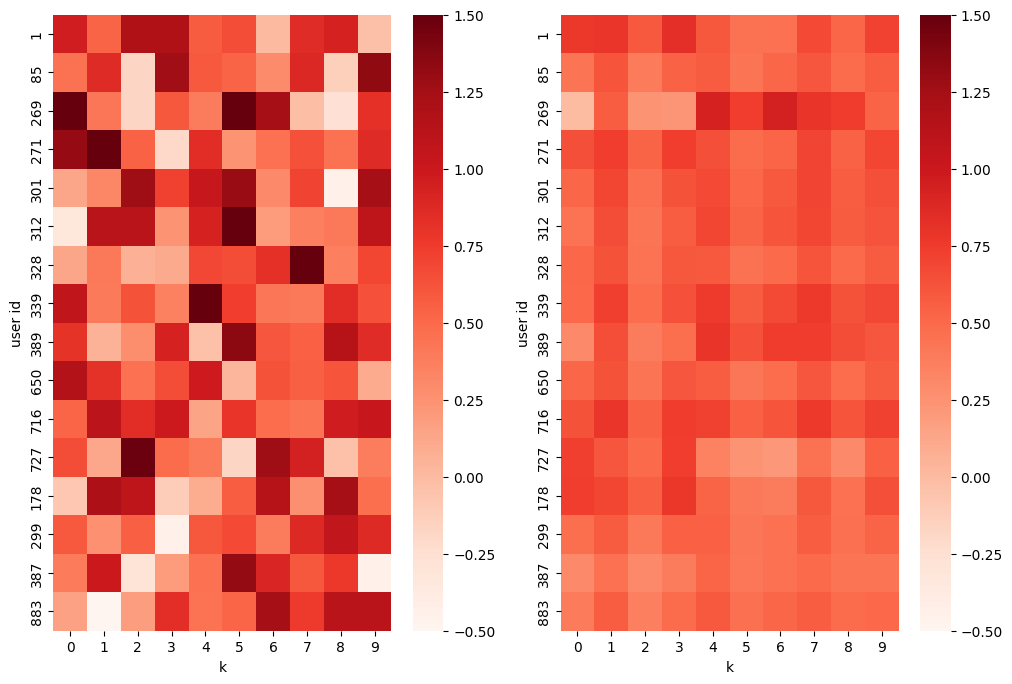

In [28]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
fig,ax = plt.subplots(figsize = (12,8), ncols = 2)
sns.heatmap(output_noreg['U'].droplevel(level=0), ax=ax[0], vmin=-0.5, vmax=1.5, cmap="Reds")
sns.heatmap(output_reg['U'].droplevel(level=0), ax=ax[1], vmin=-0.5, vmax=1.5, cmap="Reds")

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

### Question 2e: Practical Aspects

In the previous question, a specific values for $K$ and $\lambda$ were provided. Now, try applying various $K$'s and $\lambda$'s. Specifically, try the following:

 - While keeping $K$ constant, experiment with different values of $\lambda$. What do you notice? Why do you think this happens?
 - While keeping $\lambda$ constant, experiment with different values of $K$. What do you notice? Why do you think this happens?

If your optimization algorithm is correctly implemented, you will notice that the choice of $K$ and $\lambda$ has a significant impact on the final estimates. Hence, selecting appropriate values for $K$ and $\lambda$ is crucial when applying the recommendation algorithm in practice. As a practitioner, how would you approach choosing $K$ and $\lambda$?

Provide reasoning supported by evidence, such as code implementation and results.

**SOLUTION**

We first note that K encodes the number of characteristics, and $\lambda$ is the penalization term in regularization. We operate on the `Rsmall` dataset, and start by analyzing the effects of varying $\lambda$ with K constant. 

In [29]:
# keeping K constant, vary lambda
output_L1 = compute_UV_reg(Rsmall, K=10, lam=1, alpha=0.001)
output_L5 = compute_UV_reg(Rsmall, K=10, lam=5, alpha=0.001)
output_L10 = compute_UV_reg(Rsmall, K=10, lam=10, alpha=0.001)

# compare max_updates 
fig_updates_L1 = \
    alt.Chart(output_L1['update'].iloc[:900,:])\
    .mark_line()\
    .encode(
        x='iteration:Q', 
        y=alt.Y('max update:Q', scale = alt.Scale(type = "log", domain = [0.0001, 300]))
    ).properties(
    title = "lambda 1") 

fig_updates_L5 = \
    alt.Chart(output_L5['update'])\
    .mark_line()\
    .encode(
        x='iteration:Q', 
        y=alt.Y('max update:Q', scale =  alt.Scale(type = "log", domain = [0.0001, 300]))
    ).properties(
    title = "lambda 5")

fig_updates_L10 = \
    alt.Chart(output_L10['update'])\
    .mark_line()\
    .encode(
        x='iteration:Q', 
        y=alt.Y('max update:Q', scale =  alt.Scale(type = "log", domain = [0.0001, 300]))
    ).properties(
    title = "lambda 10")

alt.vconcat(
    fig_updates_L1 | fig_updates_L5 &
    fig_updates_L10
)

alt.VConcatChart(...)

As seen from the graphs above, increasing $\lambda$ while keeping K constant has the effect of 1. less extreme update sizes as the value of $\lambda$ increases, 2. reduced flucatuations, and 3. quicker convergence towards 0. This is due, again, to the fact that regularization penalizes ie., reduces the effect of larger weights in the model, thereby preventing overfitting and producing more accurate predictions for new, previously unseen data. This is evident in the plots: update sizes in the model with $\lambda = 10$ converges the quickest with minimal fluctuations from the outset, while updates in the model with $\lambda = 1$ fluctuates and converges very slowly. 


We now analyze the effect of varying K while keeping $\lambda$ constant.

In [30]:
# keeping lambda constant, vary K 
output_K10 = compute_UV_reg(Rsmall, K=10, lam=5, alpha=0.001)
output_K20 = compute_UV_reg(Rsmall, K=20, lam=5, alpha=0.001)
output_K30 = compute_UV_reg(Rsmall, K=20, lam=5, alpha=0.001)


# compare max_updates 
fig_updates_K10 = \
    alt.Chart(output_K10['update'].iloc[:900,:])\
    .mark_line()\
    .encode(
        x='iteration:Q', 
        y=alt.Y('max update:Q', scale = alt.Scale(type = "log", domain = [0.0001, 300]))
    ).properties(
    title = "K = 10") 

fig_updates_K20 = \
    alt.Chart(output_K20['update'])\
    .mark_line()\
    .encode(
        x='iteration:Q', 
        y=alt.Y('max update:Q', scale =  alt.Scale(type = "log", domain = [0.0001, 300]))
    ).properties(
    title = "K = 20")

fig_updates_K30 = \
    alt.Chart(output_K30['update'])\
    .mark_line()\
    .encode(
        x='iteration:Q', 
        y=alt.Y('max update:Q', scale =  alt.Scale(type = "log", domain = [0.0001, 300]))
    ).properties(
    title = "K = 30")

alt.vconcat(
    fig_updates_K10 | fig_updates_K20 &
    fig_updates_K30
)

alt.VConcatChart(...)

In the graphs above, we can see the effects of varying the number of characteristics K while keeping $\lambda$ constant at 5. Increasing K has the opposite effect on the size of updates of increasing $\lambda$. When K is 10, we see that convergence occurs rather quickly with minimal fluctuations. But when we increasing K to 20, or even 30, there appears to be larger fluctuations, expecially at the beginning of the algorithm, and slower convergence overall. This may be due to the fact that larger values of K increases the complexity of the model, thereby increasing the likelihood of overfitting. 

In choosing K and $\lambda$, I would consider the desired complexity of my model and weigh flexibility vs. interpretability. Data with too many attributes ie., too many characteristics K may result in overfitting, but may also be overall more representative ("cover more ground" so to say). On the other hand, data with too few attributes may fail to capture the true patterns in the phenomena being studied. I would have to assess which aspect I find more important. I would choose a larger penalty term for more complex models, and a smaller term for simpler models (ie., those with smaller K to begin with). In choosing my penalty term, I would also perform cross-validation to test various $\lambda$ terms to identify ones that yield the most accurate predictions (ie., give lowest RMSE on the validation set). 

<!-- END QUESTION -->

## Question 3: Segmentation in Latent Factor Space

Now that we have user matrix $U$ and movie matrix $V$, suppose we want to use the newly learned representation for an advertising campaign. 

Suppose you are leading the planning of an online advertising campaign and you have a fixed budget. With the budget, you can create 5 variations of an ad, and you want to create the variations based on a representative movie each group likes.

The advertisements will entice the viewer to sign up for a mailing list by offering a free poster. The goal of the advertising campaign is two fold: 

1. Get potential customers to sign up using their email address by offering a free poster among the 5 "representative" movies
2. Learn their user segment placement preference to use for the starting point for movie recommendations once they sign up

In order to achieve this goal, we want to 
1. Produce clusterings of users
2. Balance performance metric of clustering results and practical considerations to choose one of the clustering results.

We will tackle this step by step.

<!-- BEGIN QUESTION -->

### Question 3a: Concatenate matrix factors and cluster

Entries in either matrix factors are just points in $k$-dimensional latent variable space. We will use both $U$ and $V$ for segmentation by combining them into one large clustering problem.

Once clusters are identified, you will qualitatively inspect the users and movies in the cluster and decide on a "representative" movie from each cluster.

Consider concatenating $U$ and $V$ into one large matrix. Since these matrices have arbitrary scaling, it would be a good idea to standardize the columns before concatenating them. Standardize $U$ and $V$ separately, then concatenate with numpy's `concatenate` method. Call this concatenated matrix, `UVstd`.

Apply hierarchical and K-means clustering methods on `UVstd`.  For each clustering method, identify 5 clusters. Compare the clustering results by applying three different [cluster validation metrics](https://scikit-learn.org/stable/modules/clustering.html#clustering-performance-evaluation) to evaluate the clustering performance. 

Which cluster performance metrics can you use? Do we have true labels? Does one performance metric seem to clearly be better than another? Why would you choose one metric over another? What interpretation, if any, does each metric have in the context of our problem? Explain.

**SOLUTION**

In [31]:
# standardize U 
Ustd = output4['U'].subtract(output4['U'].mean())/output4['U'].std()

# standardize V 
Vstd = output4['V'].subtract(output4['V'].mean())/output4['V'].std()

In [32]:
# verify standardization
Vstd.describe().round(2).iloc[1:3,:]  # means 0, std 1 

k,0,1,2,3,4,5,6,7,8,9
mean,0.0,0.0,0.0,-0.0,0.0,0.0,-0.0,0.0,-0.0,0.0
std,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


In [33]:
# verify standardization
Ustd.describe().round(2).iloc[1:3,:]  # mean 0, std 1

k,0,1,2,3,4,5,6,7,8,9
mean,-0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.0,-0.0
std,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


In [34]:
# concatenate
UVstd = np.concatenate((Ustd,Vstd))

In [35]:
%%capture  
    # capture warnings

# clustering 
from sklearn.cluster import AgglomerativeClustering, KMeans

hier_model = AgglomerativeClustering(5).fit(UVstd) 
kmeans_model = KMeans(5).fit(UVstd)       

In our case, ground truth labels are not known. This means we are restricted in terms of which cluster performance metrics we can use. In this project, we will use the Silhouette coefficient, the Calinski-Harabasz Index, and the Davies-Bouldin Index.

The Silhouette coefficient evaluates performance using the model itself, where a higher score relates to a model with better defined clusters. It is composed of two scores: a, the mean distance between a sample and all other points in the same class, and b, the mean distance between a sample and all other points in the next nearest cluster. The coefficient is thus defined as follows: $$s = \frac{b-a}{max(a,b)}$$ where $-1 ≤ s ≤ 1$. 

From our analysis, the Silhouette coefficient indicates that the hierarchical model performs slightly better. 

In [36]:
# silhouette coefficient 
from sklearn import metrics
k_labels = kmeans_model.labels_
h_labels = hier_model.labels_ 

k_sscore = metrics.silhouette_score(UVstd, k_labels, metric='euclidean')
h_sscore = metrics.silhouette_score(UVstd, h_labels, metric='euclidean')

k_sscore, h_sscore  

(0.12260469401017422, 0.13018864944692135)

The Calinski-Harabasz Index, also known as the variance ratio criterion, is another metric we can use to evaluate a model when ground truth labels are not known. Like the previous metric, a higher score indicates a model with better defined clusters. This metric indicates that, again, the hierarchical model performs slightly better.

In [37]:
# calinski-harabasz index
k_chscore = metrics.calinski_harabasz_score(UVstd, k_labels)
h_chscore = metrics.calinski_harabasz_score(UVstd, h_labels)

k_chscore, h_chscore  

(4.220296405129359, 4.367440857998727)

The Davies-Bouldin index signifies the average ‘similarity’ between clusters, where the similarity is a measure that compares the distance between clusters with the size of the clusters themselves. It can be interpreted in the opposite way as the previous metrics: a lower score relates to a model with better separation between the clusters. Zero is the lowest possible score, and values closer to zero indicates a better partition. This metric indicates better performance for the KMeans model over the hierarchical model.

In [38]:
# davies-bouldin index
k_dbscore = metrics.davies_bouldin_score(UVstd, k_labels)
h_dbscore = metrics.davies_bouldin_score(UVstd, h_labels)

k_dbscore, h_dbscore

(1.5464106788499539, 1.631722276209111)

Why would you choose one metric over another? What interpretation, if any, does each metric have in the context of our problem? Explain.

If it were up to me, I would choose the Davis-Bouldin index for two reasons: its computation is simpler than that of Silhouette scores, and the index is solely based on quantities and features that are inherent to the dataset as its computation only uses point-wise distances. Though it has some drawbacks common to all three metrics (ie., higher scores for convex clusters), I think the Davis-Bouldin index is comprehensive as its computation incorporates both the "within-cluster" distances (ie., the cluster diameters, or the average distance between each point of a given cluster and the centroid of that cluster) and the distance between clusters themselves. 


<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

### Question 3b: Visualizing Clusters in Latent Space

Select the clustering method based on the evaluation results in q3a and visualize the clusters using [UMAP](https://umap-learn.readthedocs.io/en/latest/basic_usage.html). Are the clusters and UMAP projection consistent?

**SOLUTION**

In [39]:
%%capture
# install umap
!pip install umap-learn  

In [42]:
%%capture
import umap
reducer = umap.UMAP()
embedding = reducer.fit_transform(UVstd)

In [52]:
user_id = Rsmall.columns.to_numpy()  # since UVstd is based on output4 (using Rsmall)
movie_title = Rsmall.index.to_numpy()
user_movie_index = np.concatenate([user_id, movie_title])
embedding_df = pd.DataFrame(embedding, index = user_movie_index)

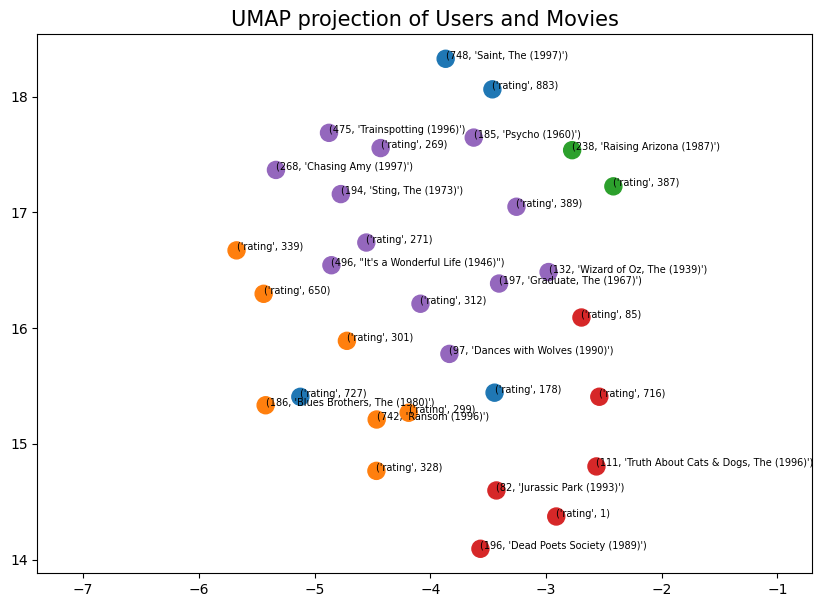

In [51]:
import matplotlib.pyplot as plt
import seaborn as sns

# k-means plot 
plt.figure(figsize = (10,7))
plt.scatter(
    embedding[:,0],
    embedding[:,1],
    s=150,
    c = [sns.color_palette()[x] for x in k_labels])

plt.gca().set_aspect('equal','datalim')
plt.title('UMAP projection of Users and Movies', fontsize=15)

# annotate each point w/ user id and movie title 
for i, txt in enumerate(user_movie_index): 
    plt.annotate(txt, (embedding[i,0], embedding[i,1]),fontsize = 7)

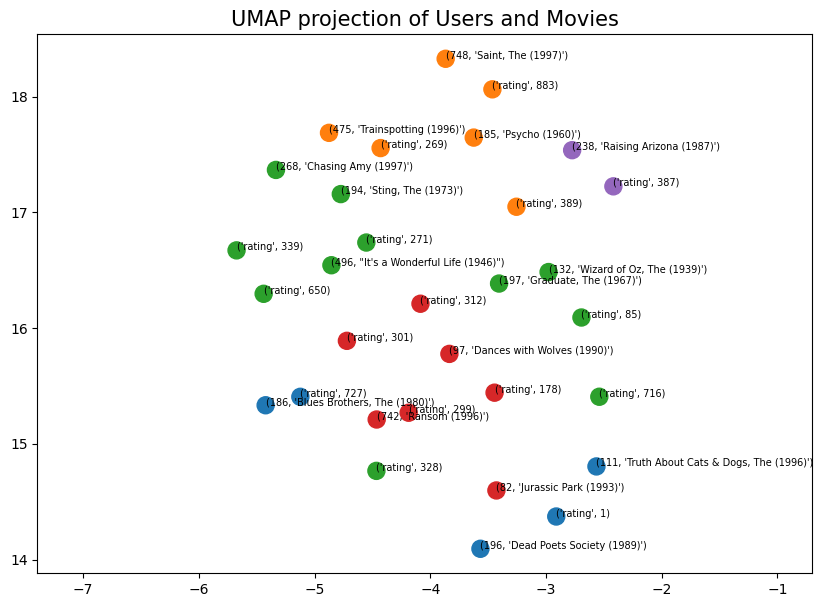

In [53]:
# hierarchical plot
plt.figure(figsize = (10,7))
plt.scatter(
    embedding[:,0],
    embedding[:,1],
    s=150,
    c = [sns.color_palette()[x] for x in h_labels])  # h_labels instead of k_labels

plt.gca().set_aspect('equal','datalim')
plt.title('UMAP projection of Users and Movies', fontsize=15)

# annotate each point w/ user id and movie title 
for i, txt in enumerate(user_movie_index): 
    plt.annotate(txt, (embedding[i,0], embedding[i,1]),fontsize = 7)

From the plots, we can determine that the clusters and UMAP projection are indeed consistent –– points within the same cluster (points that are the same color) appear close to each other, with the exception of a few points. 

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

### (PSTAT 234) Question 3c: Making decisions


To make actionable decisions, there are practical considerations to take into account.

1. How will you choose a "representative" movie from each cluster?
2. How many of each poster do you estimate you will need? Assume the ad campaign will serve 10 million users and 0.01% people will respond. What other assumption do you need to make?
3. Which clustering method will you use as the final method?

**SOLUTION**

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

## (PSTAT 234) Question 4: Improving the Model

### Question 4a: Logistic function 

Note the reconstructed ratings can be smaller than 1 and greater than 5. To confine ratings to between the allowed range, we can use the logistic function. Logistic function is defined as 
$$ h(x) = \frac{1}{1+e^{-x}}. $$
It is straightforward to show the derivative is 
$$ h'(x) = \frac{e^{-x}}{(1+e^{-x})^2} = h(x)(1-h(x)). $$
Therefore, we can rescale the ratings from $r_{mi}\in [1, 5]$ to $r_{mi}\in [0, 1]$. Then, we can find the best $U$ and $V$ to optimize the following:
$$ \min_{U,V} \| R - h(VU^T) \|_F^2 = \sum_{m,i} I_{mi}(r_{mi} - h(v_m u_i^T))^2, $$
where function $h$ is applied elementwise and 
$$
\begin{aligned}
I_{mi} = \begin{cases}
1 \text{, if $r_{mi}$ is observed}\\
0 \text{, if $r_{mi}$ is missing.}\\
\end{cases}
\end{aligned}
$$

Derive new update expressions for the new objective function.

**SOLUTION**

<!-- END QUESTION -->

### Quesiton 4b: Implementation

Implement the update functions in functions below.

In [ ]:
def logistic(x):
    """
    Evaluates logistic function
    
    """
    return 1/(1+np.exp(-x))

def update_logistic_G(R_, U_, V_):
    
    return ...

def update_logistic_U(G_, U_, V_, alpha=0.01):
    
    logisticVUT = ...              # estimated ratings
    grad = -2 * np.nan_to_num(...) # gradient direction
    return ...                     # gradient descent update from U_

def update_logistic_V(G_, U_, V_, alpha=0.01):
    
    logisticVUT = ...              # estimated ratings
    grad = -2 * np.nan_to_num(...) # gradient direction
    return ...                     # gradient descent update from V_

# small test to help debug (keep intact)
np.random.seed(1)

M_ = 5
I_ = 3
K_ = 2

R_ = np.random.rand(M_, I_).round(1)
R_[0, 0] = R_[3, 2] = np.nan
U_ = np.random.rand(I_, K_).round(1)
V_ = np.random.rand(M_, K_).round(1)
G_ = update_G(R_, U_, V_)

In [ ]:
grader.check("q4b1")

Now create a function `compute_logistic_UV` below:

In [ ]:
def compute_logistic_UV(Rdf, K=5, alpha=0.01, max_iteration=5000, diff_thr=1e-3):

    R = Rdf.values
    R = (R.copy()-1)/4         # map ratings to between 0 and 1
    Rone = pd.DataFrame().reindex_like(Rdf).replace(np.nan, 1) # keep data frame metadata

    M, I = R.shape                 # number of movies and users
    U = np.random.rand(I, K)-0.5   # initialize with random numbers
    V = np.random.rand(M, K)-0.5   # initialize with random numbers
    G = update_G(R, U, V)          # calculate residual

    track_rmse = []
    track_update = []
    for i in range(0, max_iteration): 
        
        Unew = update_logistic_U(..., ..., ..., ...)
        Gnew = update_logistic_G(..., ..., ...)

        Vnew = update_logistic_V(..., ..., ..., ...)
        Gnew = update_logistic_G(..., ..., ...)

        track_rmse += [{
            'iteration':i, 
            'rmse': rmse(Gnew),
            'max residual change': max_update(Gnew, G, relative=False)
        }]
        track_update += [{
            'iteration':i, 
            'max update':max(max_update(Unew, U), max_update(Vnew, V))
        }]

        U = Unew
        V = Vnew
        G = Gnew
        
        if track_update[-1]['max update'] < diff_thr:
            break
        
    track_rmse = pd.DataFrame(track_rmse)
    track_update = pd.DataFrame(track_update)
    
    kindex = pd.Index(range(0, K), name='k')
    U = pd.DataFrame(U, index=..., columns=...)
    V = pd.DataFrame(V, index=..., columns=...)
    
    return {
        'U':U, 'V':V,
        'rmse': track_rmse,
        'update': track_update
    }

def logistic_rating(U_, V_):
    """
    converts the rating back to 1 to 5 rating
    """
    return(4*logistic(V_@U_.T) + 1 )
    
np.random.seed(134) # set seed for tests
output5 = compute_logistic_UV(Rsmall, K=10, alpha=0.05)

In [ ]:
grader.check("q4b2")

<!-- BEGIN QUESTION -->

### Question 4c: Analyze a Large Dataset

Following code will analyze a larger dataset:

In [ ]:
# run on larger dataset: ratings for 100 movies 
Rbig = pd.read_pickle('data/ratings_stacked.pkl').unstack().iloc[:100]

np.random.seed(14) # set seed for tests
output6 = compute_logistic_UV(Rbig, K=5, alpha=0.05, max_iteration=500)

Rhatbig = logistic_rating(output6['U'], output6['V'])

In [ ]:
fit_vs_obs_2 = pd.concat([
    Rhatbig.rename(columns={'rating':'fit'}),
    Rbig.rename(columns={'rating':'observed'}),
], axis=1).stack().dropna().reset_index()[['fit','observed']]

fit_vs_obs_2 = fit_vs_obs_2.iloc[np.random.choice(len(fit_vs_obs_2), 5000)]

alt.Chart(fit_vs_obs_2).transform_density(
    density='fit',
    bandwidth=0.01,
    groupby=['observed'],
    extent= [0, 6]
).mark_bar().encode(
    alt.X('value:Q'),
    alt.Y('density:Q'),
    alt.Row('observed:N')
).properties(width=800, height=50)

Consider the above plot. By reading the code, comment on what the plot is illustrating. How does this plot look different than part 1.e?

**SOLUTION**

<!-- END QUESTION -->

_Cell Intentionally Blank_

## Submission

Make sure you have run all cells in your notebook in order before running the cell below, so that all images/graphs appear in the output. The cell below will generate a zip file for you to submit. **Please save before exporting!**

Download the zip file and submit to Gradescope.

In [ ]:
# Save your notebook first, then run this cell to export your submission.
grader.export(run_tests=True)